In [2]:
!pip install geocoder

!pip install -c conda-forge geopy --yes  
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install -c conda-forge folium=0.5.0 --yes  
###import folium # map rendering library

     |████████████████████████████████| 102kB 7.9MB/s ta 0:00:011

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [3]:
!pip install folium

     |████████████████████████████████| 92kB 17.5MB/s eta 0:00:01


In [4]:
import folium

In [5]:
from bs4 import BeautifulSoup
import requests
import re 
import pandas as pd, numpy as np
import geocoder
import io

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


## References used:
#Lab: New York, FourSquare API and clustering
#https://stackoverflow.com/questions/50355577/scraping-wikipedia-tables-with-python-selectively
#https://stackoverflow.com/questions/42776834/get-the-title-of-a-link-using-beautifulsoup
#https://stackoverflow.com/questions/46275765/pandas-merge-row-data-with-multiple-values-to-python-list-for-a-column
#https://www.geeksforgeeks.org/python-program-split-join-string/
#https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url

In [6]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

res = requests.get(URL).content   
soup = BeautifulSoup(res,'lxml')

all_items = []
# Find all with "tr"
for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
    # Find items in the table
    data = items.find_all(['th','td'])

    # Get the raw strings
    postcode = str(data[0].contents[0] )
    borough_1 = str(data[1].contents[0] )
    neighbourhood_1 = str(data[2].contents[0] )

    # Remove links in Borough, if any
    if re.search(   '</a>'  , borough_1 ) :
      borough = re.split('>|<|</a>',  borough_1  ) [-3:-2][0]  
    else : 
      borough = borough_1
    
    # Remove links in Neighbourhood, if any
    if re.search(   '</a>'  , neighbourhood_1 ) :
      neighbourhood = re.split('>|<|</a>',  neighbourhood_1  ) [-3:-2][0] 
    else :
      neighbourhood = neighbourhood_1
    
    # Remove Extra line breaks if they appear
    postcode = re.sub(r'\n', '', postcode)   
    borough = re.sub(r'\n', '', borough)   
    neighbourhood = re.sub(r'(\n)', r'', neighbourhood) 
    if neighbourhood == "Not assigned" :
      neighbourhood = borough

    # Create the new row, and add to the list
    if borough != "Not assigned" :
      new_row = [postcode, borough, neighbourhood]
      all_items.append(new_row)

In [7]:
# Creating a dataframe object from list of lists
all_items_df = pd.DataFrame(all_items) 
all_items_df.columns =['PostalCode', 'Borough', 'Neighbourhood'] 

# For PostCode with multiple Neighborhood, collapse them into a list
grouped_df = all_items_df.groupby(['PostalCode', 'Borough']).agg(lambda x: ', '.join( tuple(x)  )  ).reset_index()    
 
# Sort by postal code
Toronto_df = grouped_df.sort_values(['PostalCode'])

## Toronto_df.head()
## Toronto_df.shape

In [8]:
# Load data from the csv file
geo_URL="http://cocl.us/Geospatial_data"
geo_bytes=requests.get(geo_URL).content
geo_data=pd.read_csv(io.StringIO(geo_bytes.decode('utf-8')))
## print( geo_data.head() )

In [9]:
Toronto_LatLong = pd.merge(Toronto_df, geo_data, left_on='PostalCode', right_on='Postal Code')[['PostalCode', 'Borough', 'Neighbourhood','Latitude','Longitude']]

##Toronto_LatLong.head()

In [10]:
address = 'Toronto, ON'  

geolocator = Nominatim(user_agent="ON_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
## print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

In [11]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[  latitude, longitude ], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_LatLong['Latitude'], Toronto_LatLong['Longitude'], Toronto_LatLong['Borough'], Toronto_LatLong['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
### map_Toronto

In [12]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

##print('Your credentails:')
##print('CLIENT_ID: ' + CLIENT_ID)
##print('CLIENT_SECRET:' + CLIENT_SECRET)


LIMIT = 100 #100 # limit of number of venues returned by Foursquare API

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        ##### print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        ##### print(type(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:

toronto_venues = getNearbyVenues(names=Toronto_LatLong['Neighbourhood'],
                                   latitudes=Toronto_LatLong['Latitude'],
                                   longitudes=Toronto_LatLong['Longitude']
                                  )

In [15]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
## toronto_grouped

In [17]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood'].head() :
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2               Skating Rink   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood / Long Branch----
            venue  freq
0     Pizza Place  0.25
1        Pharmacy  0.12
2    Skating Rink  0.12
3  Sandwich Place  0.12
4             Pub  0.12


----Bathurst Manor / Wilson Heights / Downsview North----
                 venue  freq
0                 Bank  0.10
1          Coffee Shop  0.10
2                Diner  0.05
3       Ice Cream Shop  0.05
4  Fried Chicken Joint  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2   Chinese Restaurant  0.25
3  Japanese Restaurant  0.25
4        Movie Theater  0.00


----Bedford Park / Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2          Restaurant  0.08
3  

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Clothing Store,Latin American Restaurant
1,Alderwood / Long Branch,Pizza Place,Sandwich Place,Gym,Skating Rink,Coffee Shop
2,Bathurst Manor / Wilson Heights / Downsview North,Bank,Coffee Shop,Shopping Mall,Pharmacy,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Distribution Center
4,Bedford Park / Lawrence Manor East,Sandwich Place,Restaurant,Italian Restaurant,Coffee Shop,Liquor Store


In [20]:

toronto_merged = Toronto_LatLong
toronto_merged.columns = ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']

## Introduction

The purpose of this study is to decide which is the best neighborhood for a new Italian restaurant in Toronto. We are advising a chef from another part of Canada on where is the best place in Toronto to open a new restaurant. The audience for this study is anyone who is thinking of opening an Italian cafe or restaurant in Toronto, and needs help deciding where is the best location. The criteria for deciding where to place the new Italian restaurant includes two main points:

1. The new Italian restaurant should not be in the same neighborhood as an existing Italian restaurant

2. The neighborhood chosen should have a lot in common with the neighborhoods that already have Italian restaurants. For example, if we find that it is common for Italian restaurants to be located in neighborhoods that also have Mexican restaurants, then we would like to find a neighborhood with a Mexican restaurant to open our new Italian restaurant.

These two criteria ensure that the new Italian restaurant will be in a location that is similar to the neighborhoods that already have Italian restaurants, but won't be too close to an existing Italian restaurant.

## Data

The data for this study comes from Wikipedia, the Python _geocoder_ package, and FourSquare. Wikipedia provides names and postcodes for 10 boroughs and 103 neighborhoods in Toronto. The _geocoder_ package was used to create the csv file of longitude and latitude values for each Toronto neighborhood, and this csv file was provided by Coursera. Foursquare will be used to look up each neighborhood by it's coordinates and provide a list of all businesses in that area. The Foursquare data will let us see which neighborhoods already have at least one Italian restaurant, and also what other types of businesses may be present.

#### Wikipedia data

This shows the boroughs and neighborhood names available from Wikipedia. The PostalCode can be joined to the _geocoder_ csv output to find longitude and latitude, which allows for _folium_ map visualizations

In [21]:
# Check how many boroughs and neighbourhoods there are
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Toronto_LatLong['Borough'].unique()),
        Toronto_LatLong.shape[0]
    )
)
print("Boroughs are ", Toronto_LatLong['Borough'].unique())
Toronto_df.head()

The dataframe has 10 boroughs and 103 neighborhoods.
Boroughs are  ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' 'Mississauga' 'Etobicoke']


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### _geocoder_ data
This is the Latitude and Longitude values for map plotting

In [22]:
 geo_data.head() 

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Foursquare
These are the top 10 venue categories in Toronto. Italian restaurants are already in the top 10, so we need to find neighborhoods that don't have one yet. Also, an interesting finding will be to see how Pizza Place trends with Italian restaurant. We will have to decide whether our new restaurant should be in a location that already has a pizza place.

In [23]:
 toronto_venues['Venue Category'].value_counts().head(10)

Coffee Shop            173
Café                   101
Restaurant              73
Park                    52
Italian Restaurant      51
Pizza Place             47
Hotel                   42
Sandwich Place          40
Japanese Restaurant     39
Bakery                  36
Name: Venue Category, dtype: int64

## Methodology

We will use FourSquare data to find which neighborhoods meet the two main criteria of not already having an Italian restaurant in the top 100 results listed, but being similar to neighborhoods that do have one.

1. The first step is to identify which restaurants already have an Italian restaurant in their first 100 FourSquare results. This is straightforward, and can be checked using the one-hot encoded dataset.

2. The second step is to use cosine similarity on the one-hot vectors for each of about 100 neighborhoods to compare each neighborood without an Italian restaurant to each neighborhood that already has an Italian restaurant. Each neighborhood without an Italian restaurant will have one cosine similarity score between itself and each of the neighborhoods with an Italian restaurant. Then, all these scores will be summed for all those neighborhoods without an Italian restaurant to create a final score that will be used to rank that neighborhood's overall similarity with the neighborhoods that do have an Italian restaurant.

The top 10 neighborhoods according to this ranking will be presented to the Italian chefs to help them decide the best location to introduce a new Italian restaurant for the first time for that neighborhood.

#### Labeling based on already existing Italian places

We will label each neighborhood based on whether or not it already has at least one Italian restaurant, or at least one Pizza place. Note that we will not consider how many Italian restaurants they are, or what percent of total business are Italian restaurants, just whether or not at least one is present.

In [24]:
toronto_Italian_labels = toronto_grouped.copy()

toronto_Italian_labels['Italian_Places'] = np.where(  (toronto_Italian_labels['Italian Restaurant']>0) & (toronto_Italian_labels['Pizza Place'] ==0) , 1, 
                         np.where(  (toronto_Italian_labels['Pizza Place'] >0) & (toronto_Italian_labels['Italian Restaurant'] ==0)  , 2,
                           np.where( (toronto_Italian_labels['Italian Restaurant'] >0) & (toronto_Italian_labels['Pizza Place'] >0)  , 3,0 )))  #and (toronto_Italian_labels['Pizza Place'] >0)

toronto_Italian_labels['Italian_Labels'] = np.where(  (toronto_Italian_labels['Italian_Places']==1) , "Italian Restaurant, no Pizza Place", 
                         np.where(  (toronto_Italian_labels['Italian_Places'] ==2 )   , "Pizza Place but no Italian Restaurant",
                           np.where( (toronto_Italian_labels['Italian_Places'] ==3 )  , "Both Italian Restaurant and Pizza Place", "Neither Italian Restaurant or Pizza Place" )))  #and (toronto_Italian_labels['Pizza Place'] >0)


toronto_Italian_labels[ ["Neighborhood", "Italian Restaurant", "Pizza Place", 'Italian_Places', 'Italian_Labels'] ].head(10)    #toronto_merged
#print(toronto_grouped.columns )
# print(  len(toronto_grouped["Neighborhood"])   )
# print(  len(toronto_grouped["Neighborhood"].unique()  )   )

,Neighborhood,Italian Restaurant,Pizza Place,Italian_Places,Italian_Labels
0,Agincourt,0.000000,0.0000,0,Neither Italian Restaurant or Pizza Place
1,Alderwood / Long Branch,0.000000,0.2500,2,Pizza Place but no Italian Restaurant
2,Bathurst Manor / Wilson Heights / Downsview North,0.000000,0.0500,2,Pizza Place but no Italian Restaurant
3,Bayview Village,0.000000,0.0000,0,Neither Italian Restaurant or Pizza Place
4,Bedford Park / Lawrence Manor East,0.080000,0.0400,3,Both Italian Restaurant and Pizza Place
5,Berczy Park,0.036364,0.0000,1,"Italian Restaurant, no Pizza Place"
6,Birch Cliff / Cliffside West,0.000000,0.0000,0,Neither Italian Restaurant or Pizza Place
7,Brockton / Parkdale Village / Exhibition Place,0.043478,0.0000,1,"Italian Restaurant, no Pizza Place"
8,Business reply mail Processing CentrE,0.000000,0.0625,2,Pizza Place but no Italian Restaurant
9,CN Tower / King and Spadina / Railway Lands / ...,0.000000,0.0000,0,Neither Italian Restaurant or Pizza Place


#### Preliminary results on neighborhoods by presence of Italian restaurants

Preliminary results sshow that about half of neighborhoods in Toronto do not have either an Italian restaurant or Pizza place yet, and any of these is a possible candidate for our future Italian restaurant. Also, some neighborhoods do have at least one pizza place, and we will be exploring whether it makes sense to put our Italian restaurant in a neighborhood that already has a pizza place. The neighborhoods that already have Italian restaurants are important to our study because we will use them to find out what characteristics make a neighborhood friendly to Italian restaurants.

In [25]:
Italian_freq = toronto_Italian_labels.groupby( ['Italian_Labels','Italian_Places'] ).size().to_frame().reset_index()
Italian_freq.columns = ['Italian_Labels','Italian_Places', 'Counts']
#print(  type(Italian_freq)  )
Italian_freq

,Italian_Labels,Italian_Places,Counts
0,Both Italian Restaurant and Pizza Place,3,15
1,"Italian Restaurant, no Pizza Place",1,11
2,Neither Italian Restaurant or Pizza Place,0,49
3,Pizza Place but no Italian Restaurant,2,19


## Results

The first step in results is visualizing the locations of neighborhoods with Italian restaurants, pizza places, or both. The orange dots show places with both Italian restaurant and pizza place, and red dots show those with Italian restaurants only. The green dots show neighborhoods with pizza places, but not Italian restaurants. The blue dots have neither Italian restaurants or pizza places. We will use the Italian restaurant neighborhoods (red and orange dots) to determine which neighborhood without an Italian restaurant (blue and green dots) is most likely a good choice to open a first Italian restaurant.

The second step is reviewing the cosine similarity results between the neighborhoods that have Italian restaurants, and those that do not.

In [75]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_Italian = toronto_merged.join(toronto_Italian_labels[ ['Neighborhood', 'Italian_Places'] ].set_index('Neighborhood'), on='Neighborhood')
toronto_merged_Italian = toronto_merged_Italian.dropna()
toronto_merged_Italian['Italian_Places'] = toronto_merged_Italian[['Italian_Places']].astype(int)

In [76]:
# create map
map_Italian = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ["#4137ab","#ab4537","#50ab37","#ab8837","#e80cdd"]  #[colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_Italian['Latitude'], toronto_merged_Italian['Longitude'], toronto_merged_Italian['Neighborhood']
                                  , toronto_merged_Italian['Italian_Places']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],     #[cluster-1],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_Italian)
       
map_Italian

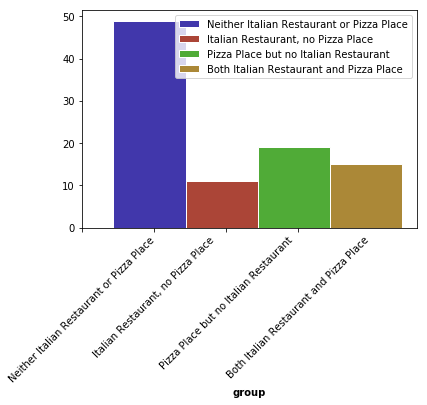

In [77]:
#print(colors_array)
#print(rainbow)

# libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
 
def get_label(label_type, label_num):
    return Italian_freq[  Italian_freq[ 'Italian_Places' ] == label_num  ][label_type].item()    
    
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [ get_label('Counts', 0) ]
bars2 = [ get_label('Counts', 1) ]
bars3 = [ get_label('Counts', 2) ]
bars4 = [ get_label('Counts', 3) ]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color=rainbow[0], width=barWidth, edgecolor='white', label=get_label('Italian_Labels', 0))
plt.bar(r2, bars2, color=rainbow[1], width=barWidth, edgecolor='white', label=get_label('Italian_Labels', 1))
plt.bar(r3, bars3, color=rainbow[2], width=barWidth, edgecolor='white', label=get_label('Italian_Labels', 2))
plt.bar(r4, bars4, color=rainbow[3], width=barWidth, edgecolor='white', label=get_label('Italian_Labels', 3))
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r/4-1/4 + barWidth/16 for r in range(4)], [get_label('Italian_Labels', x) for x in range(4) ], rotation=45)
 
# Create legend & Show graphic
plt.legend()
plt.show()


#### Cosine Similarity calculation results

Now that we've visualized the locations of neighborhoods with and without Italian restaurants, the next step is to inspect the results for which no-Italian-restaurant neighborhoods have the highest sum of cosine similarity scores with Italian-restaurant neighborhoods. From the final top 10 list, it seems that both neighborhoods with and without pizza places could be good candidates for opening up a first-time Italian restaurant.

In [78]:
# Cosine similarity between the set of neighborhoods with Italian restaurants, and those without
import scipy 

# Create two separate dataframes for those with and without Italian restaurant
has_Italian = toronto_Italian_labels[  toronto_Italian_labels['Italian_Places'].isin([1,3]) ]
no_Italian = toronto_Italian_labels[  toronto_Italian_labels['Italian_Places'].isin([0,2]) ]

# Get ready to calculate cosine similarity
def cosine_similarity(vector1, vector2):
    return 1- scipy.spatial.distance.cosine(vector1, vector2)

# Set up the matrix of results, without Italian in rows, with a column for each neighborhood that has an Italian restaurant
num_no_Ital = len(no_Italian)
num_has_Ital = len(has_Italian)

cosine_results = np.zeros( [num_no_Ital, num_has_Ital] )

# Iterate over each neighborhood pair 
for i in range( num_has_Ital ): 
    has_Ital = has_Italian.drop(  columns=['Neighborhood','Italian_Places', 'Italian_Labels']  ).iloc[i].to_numpy()
    for j in range( num_no_Ital ):
        no_Ital = no_Italian.drop(  columns=['Neighborhood','Italian_Places', 'Italian_Labels']  ).iloc[j].to_numpy()
        cosine_results[j,i] = cosine_similarity(has_Ital, no_Ital)

# Sum up cosine similarity results by neighborhood
results_no_Ital = np.sum(cosine_results, axis = 1)

# Add the final cosine score the to the list of neighborhoods with no Italian restaurants
no_Italian_results = no_Italian.copy()

no_Italian_results["Cosine_Sim_Scores"] = results_no_Ital.tolist()

no_Italian_results_ranked = no_Italian_results.sort_values("Cosine_Sim_Scores", ascending=False)

In [79]:
# Top 10 neighborhoods without Italian restaurants, but that have closest similarity to neighborhoods with Italian restaurants
no_Italian_results_ranked[['Neighborhood', 'Italian_Labels',"Cosine_Sim_Scores"]].head(10)  

,Neighborhood,Italian_Labels,Cosine_Sim_Scores
64,Richmond / Adelaide / King,Pizza Place but no Italian Restaurant,13.560804
63,Regent Park / Harbourfront,Neither Italian Restaurant or Pizza Place,11.731642
89,Willowdale,Pizza Place but no Italian Restaurant,10.539785
78,The Annex / North Midtown / Yorkville,Pizza Place but no Italian Restaurant,10.000838
43,Kensington Market / Chinatown / Grange Park,Pizza Place but no Italian Restaurant,9.924557
55,North Toronto West,Neither Italian Restaurant or Pizza Place,9.227167
53,New Toronto / Mimico South / Humber Bay Shores,Pizza Place but no Italian Restaurant,8.302159
2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place but no Italian Restaurant,8.239112
90,Woburn,Neither Italian Restaurant or Pizza Place,8.180041
27,Eringate / Bloordale Gardens / Old Burnhamthor...,Pizza Place but no Italian Restaurant,8.051736


In [80]:
top_10_results = no_Italian_results_ranked[['Neighborhood', 'Italian_Labels',"Cosine_Sim_Scores"]].head(10) 
top_10_results["Top_10_label"] = 1
top_10_results

,Neighborhood,Italian_Labels,Cosine_Sim_Scores,Top_10_label
64,Richmond / Adelaide / King,Pizza Place but no Italian Restaurant,13.560804,1
63,Regent Park / Harbourfront,Neither Italian Restaurant or Pizza Place,11.731642,1
89,Willowdale,Pizza Place but no Italian Restaurant,10.539785,1
78,The Annex / North Midtown / Yorkville,Pizza Place but no Italian Restaurant,10.000838,1
43,Kensington Market / Chinatown / Grange Park,Pizza Place but no Italian Restaurant,9.924557,1
55,North Toronto West,Neither Italian Restaurant or Pizza Place,9.227167,1
53,New Toronto / Mimico South / Humber Bay Shores,Pizza Place but no Italian Restaurant,8.302159,1
2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place but no Italian Restaurant,8.239112,1
90,Woburn,Neither Italian Restaurant or Pizza Place,8.180041,1
27,Eringate / Bloordale Gardens / Old Burnhamthor...,Pizza Place but no Italian Restaurant,8.051736,1


In [98]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_top10 = toronto_merged_Italian.join(top_10_results[ ['Neighborhood', 'Top_10_label'] ].set_index('Neighborhood'), on='Neighborhood')
toronto_merged_top10['Italian_Places'] = np.where(  (toronto_merged_top10['Top_10_label']==1) , 4, toronto_merged_top10['Italian_Places'])
toronto_merged_top10 = toronto_merged_top10.drop_duplicates(subset='Neighborhood', keep="last" )

In [99]:
toronto_merged_top10['Italian_Places'] .value_counts()

0    46
3    15
2    12
1    11
4    10
Name: Italian_Places, dtype: int64

In [100]:
# create map
map_Italian_top10 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_top10['Latitude'], toronto_merged_top10['Longitude'], toronto_merged_top10['Neighborhood']
                                  , toronto_merged_top10['Italian_Places']):
    #print(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],     #[cluster-1],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_Italian_top10)
    #print(cluster, rainbow[cluster]) 
map_Italian_top10

In [107]:
print(rainbow)
#print(toronto_venues.head() )


toronto_venues_labels = toronto_venues.join(toronto_merged_top10[ ['Neighborhood', 'Italian_Places'] ].set_index('Neighborhood'), on='Neighborhood')

print(len(toronto_venues))
print(len(toronto_venues_labels))

['#4137ab', '#ab4537', '#50ab37', '#ab8837', '#e80cdd']
2139
2139


In [115]:
print( get_label('Italian_Labels', 0) )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'] == 0 ]['Venue Category'].value_counts().head(10) )

Neither Italian Restaurant or Pizza Place

Park                      19
Coffee Shop               15
Clothing Store            13
Bank                      10
Bakery                    10
Convenience Store          8
Grocery Store              7
Sandwich Place             7
Fast Food Restaurant       7
Furniture / Home Store     6
Name: Venue Category, dtype: int64


In [116]:
print( get_label('Italian_Labels', 1) )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'] == 1 ]['Venue Category'].value_counts().head(10) )

Italian Restaurant, no Pizza Place

Coffee Shop            37
Café                   30
Italian Restaurant     17
Restaurant             12
Park                    9
Bakery                  9
Diner                   9
Japanese Restaurant     9
Bar                     9
Beer Bar                7
Name: Venue Category, dtype: int64


In [117]:
print( get_label('Italian_Labels', 2) )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'] == 2 ]['Venue Category'].value_counts().head(10) )

Pizza Place but no Italian Restaurant

Pizza Place             15
Coffee Shop              7
Sandwich Place           6
Fast Food Restaurant     6
Pharmacy                 5
Grocery Store            4
Bank                     4
Pub                      4
Park                     3
Restaurant               3
Name: Venue Category, dtype: int64


In [118]:
print( get_label('Italian_Labels', 3) )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'] == 3 ]['Venue Category'].value_counts().head(10) )

Both Italian Restaurant and Pizza Place

Coffee Shop            82
Café                   46
Restaurant             43
Italian Restaurant     34
Hotel                  28
Japanese Restaurant    22
Pizza Place            22
Gym                    17
American Restaurant    16
Bar                    15
Name: Venue Category, dtype: int64


In [131]:
num_places = len(toronto_merged_top10[  toronto_merged_top10['Italian_Places'].isin( [4] )   ] )
print( "Recommended for a new Italian Restaurant, n=", num_places  )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'] == 4 ]['Venue Category'].value_counts().head(10)      /num_places )

Recommended for a new Italian Restaurant, n= 10

Coffee Shop           3.2
Café                  2.1
Restaurant            1.1
Pizza Place           1.0
Park                  0.7
Mexican Restaurant    0.6
Sandwich Place        0.6
Bakery                0.6
Cosmetics Shop        0.5
Pharmacy              0.5
Name: Venue Category, dtype: float64


In [129]:
num_places = len(toronto_merged_top10[  toronto_merged_top10['Italian_Places'].isin( [1,3] )   ] )
print( "Already has an Italian restaurant, n=", num_places  )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'].isin( [1,3] ) ]['Venue Category'].value_counts().head(10)      /num_places )

Already has an Italian restaurant, n= 26

Coffee Shop            4.576923
Café                   2.923077
Restaurant             2.115385
Italian Restaurant     1.961538
Hotel                  1.269231
Japanese Restaurant    1.192308
Bar                    0.923077
Gym                    0.884615
Park                   0.884615
Pizza Place            0.846154
Name: Venue Category, dtype: float64


In [130]:
num_places = len(toronto_merged_top10[  toronto_merged_top10['Italian_Places'].isin( [0,2] )   ] )
print( "Doesn't have an Italian restaurant, not in Top 10, n=", num_places )
print("")
print( toronto_venues_labels[ toronto_venues_labels['Italian_Places'].isin( [0,2] ) ]['Venue Category'].value_counts().head(10)      /num_places )

Doesn't have an Italian restaurant, not in Top 10, n= 58

Coffee Shop             0.379310
Park                    0.379310
Pizza Place             0.258621
Bank                    0.241379
Clothing Store          0.224138
Fast Food Restaurant    0.224138
Sandwich Place          0.224138
Grocery Store           0.189655
Bakery                  0.189655
Pharmacy                0.155172
Name: Venue Category, dtype: float64


## Discussion

The top 10 neighborhoods that were selected as the best places for a new Italian restaurant that don't already have an Italian restaurant showed some interesting results. The locations and characteristics of these neighborhoods can help our audiences learn about what to look for in a neighborhood when deciding to introduce a new Italian restaurant.

#### Locations

The locations of existing Italian restaurants show that most of them are in the busy city center, with a few scattered out in the suburbs. The top 10 neighborhoods for a new Italian restaurant also showed this trend, with nearly every center city location that did not already have an Italian restaurant being selected, and a few also selected out in the suburbs. This is an interesting result, because distance from city center was not included as a variable. A follow-up study might include this variable to see how the likelihood of finding an Italian restaurant changes as you move away from the center.

#### Characteristics

An early hypothesis was to see whether presence of a pizza place increased the likelihood of finding an Italian restaurant, and it turns out that 7 of the top 10 recommendations do already have pizza places. But, it turns out pizza place wasn't the strongest trend found. The top 3 types of businesses in neighborhoods with Italian restaurants are Coffee Shop, Cafe, and Restaurant, and it turns out these were also the top 3 business types in the top 10 recommendations. Locations not recommended for Italian restaurants also had Coffee Shops, but were more likely to have Clothing Stores and Banks. It would be interesting to extend this analysis to other cities and see if it's common to find Italian restaurants in the same places as Cafes and Coffee Shops.

## Conclusion

In conclusion, the 10 neighborhood recommendations are the best places to start a new Italian restaurant in Toronto, assuming the chef is looking for a place that has never had an Italian restaurant before. We learned that Italian restaurants are usually found in neighborhoods that have cafes, coffee shops, and other restaurants, so the recommendations are based on finding new places that also have these types of businesses. 